
Demonstrate the usage of the basic functions.

@author: Guihong Wan and Boshen Yan      
@date: July 20, 2023    
@last updated: Aug 28, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

import spatialcells as spc


# Read data

In [2]:
adata = ad.read('../data/example_adata.h5ad')
adata.obs["id"] = adata.obs_names


# setGate or setGates

This package relies on gated biomarkers in adata.obs

If gating has not yet been performed, `setGate` and `setGates` are convenience functions to gate the dataset manually or via a csv file

In [3]:
# New columns, SOX10_positive and CD45_positive, will be added
spc.prep.setGate(adata, "SOX10", 7.5, debug = True)
spc.prep.setGate(adata, "CD45", 8.0, debug = True)

False    91523
True     46293
Name: SOX10_positive, dtype: int64
False    98518
True     39298
Name: CD45_positive, dtype: int64


In [4]:
# A column ending with "_positive" for each marker will be added
gate_file = "../data/example_gates.csv"
spc.prep.setGates(adata, gate_file, debug = True)

gate: 7.5 False    91523
True     46293
Name: SOX10_positive, dtype: int64
gate: 7.0 False    116836
True      20980
Name: CD8A_positive, dtype: int64
gate: 7.2 False    111855
True      25961
Name: CD3E_positive, dtype: int64
gate: 8.0 False    98518
True     39298
Name: CD45_positive, dtype: int64
gate: 6.5 False    129174
True       8642
Name: panCK_positive, dtype: int64
gate: 7.4 False    113595
True      24221
Name: CD4_positive, dtype: int64
gate: 5.7 False    129847
True       7969
Name: aSMA_positive, dtype: int64


In [5]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id', 'SOX10_positive', 'CD45_positive', 'CD8A_positive', 'CD3E_positive', 'panCK_positive', 'CD4_positive', 'aSMA_positive'
    uns: 'all_markers'

Visualizing cells with markers of interest

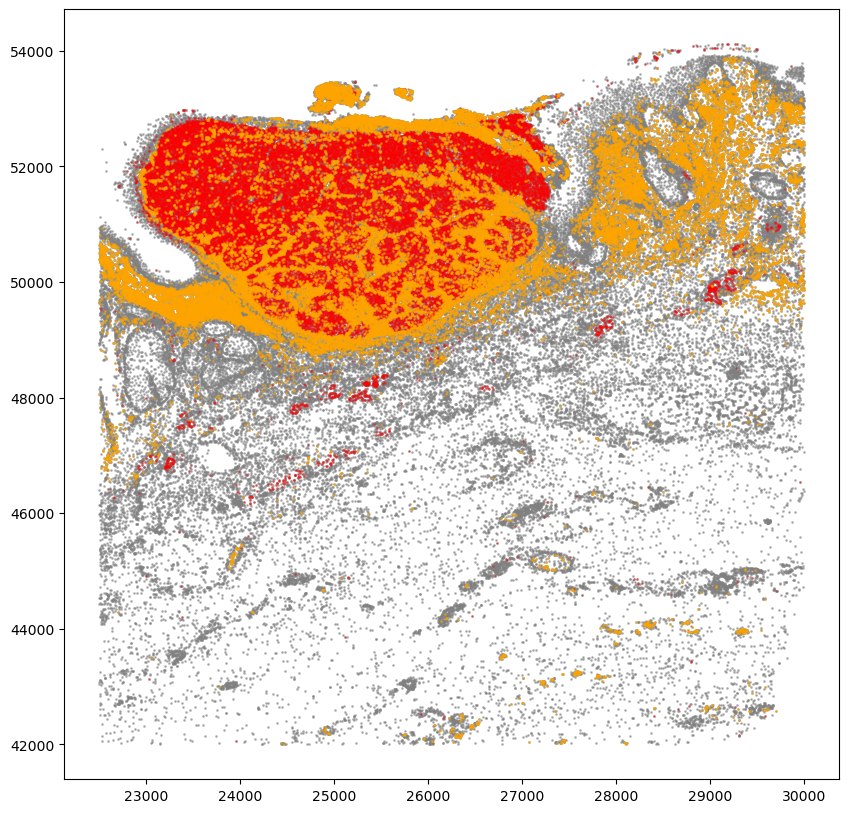

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="grey", alpha=0.5)

## SOX10+ cells
tmp = adata[adata.obs.SOX10_positive]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.3)

## CD45+ cells
tmp = adata[adata.obs.CD45_positive]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="orange", alpha=0.5)
plt.show()

The following steps compute the communities based on SOX10+ or CD45+ cells.

# getCommunities

We first use DBSCAN via `getCommunities` to identify regions with high densities of markers of interest. 

Optionally, `estimateInitialDistance` can be run first to estimate the eps parameter for DBSCAN.    
In this example, we used a threshold at the first quartile.

In [7]:
markers_of_interest = ["SOX10_positive", "CD45_positive"]
eps_estims = spc.spatial.estimateInitialDistance(adata, markers_of_interest, sampling_ratio=0.2)
eps_estims

Computing distances...


[12.857066812457886,
 22.51137232544781,
 37.03869104376509,
 58.42783531642131,
 90.10279858806813,
 124.78439230048978,
 208.70677500679466,
 363.5030798650814,
 543.6150446588998,
 852.6019952317035,
 1468.2612245884873,
 2617.063093597117,
 5305.114899815543,
 12599.008272780458,
 30937.908783228737,
 79599.6712449376,
 242028.06660597594]

In [8]:
markers_of_interest = ["SOX10_positive", "CD45_positive"]

communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, markers_of_interest, 
                                 eps= 90, 
                                 newcolumn = communitycolumn)
print("number of communities:", len(ret[0]))

number of communities: 26


Visualize the communities identified

Each community is labelled as (rank in descending number of cells : index of community)

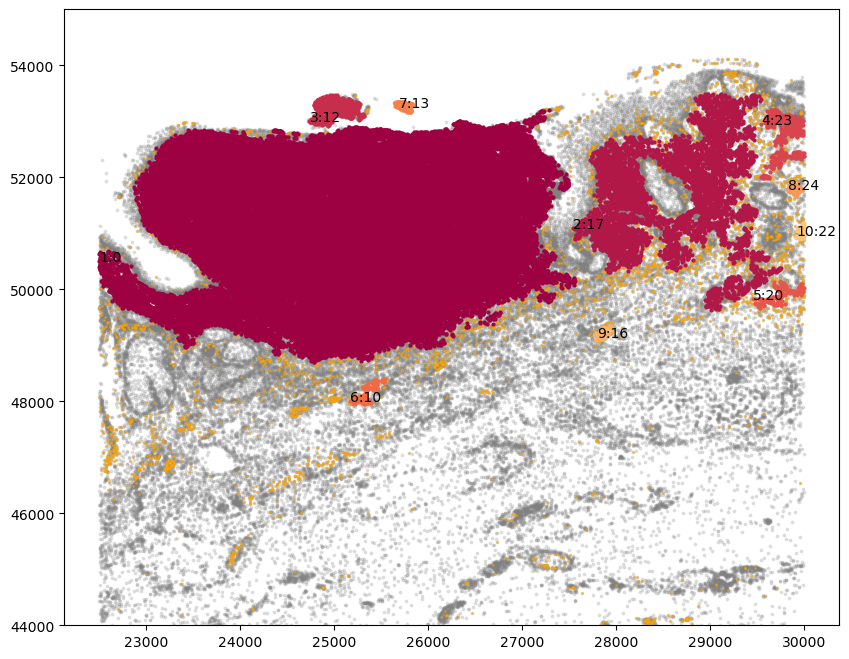

In [9]:
markersize = 2

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1
plt.ylim(44000, 55000)
plt.show()
 

In [10]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
print(clusters_idx_sorted[:plot_first_n_clusters])
print(ret[0][:plot_first_n_clusters])

# Here we choose the three largest ones of interest based on their index:
communityIndexList = [0, 17, 12]

[0, 17, 12, 23, 20, 10, 13, 24, 16, 22]
[(68681, 0), (7543, 17), (1218, 12), (600, 23), (234, 20), (167, 10), (161, 13), (82, 24), (75, 16), (67, 22)]


# getBoundary    

In [11]:
help(spc.spatial.getBoundary)

Help on function getBoundary in module spatialcells.spatial._getBoundary:

getBoundary(anndata, communitycolumn, communityIndexList, alpha=100, nedges_min=20, nedges_out_min=20)
    Get the boundary of the communities of interest
    :param anndata: the anndata object
    :param communitycolumn: the column name of the community
    :param communityIndexList: the list of community indexes
    :param alpha: the alpha parameter for alpha shape. Smaller alpha gives
        more detailed boundary, but may appear more jagged.
    :param nedges_min: the minimum number of edges to keep a hole inside a
        component's boundary
    :param nedges_out_min: the minimum number of edges for a component to be
        considered as an "out" region
    :return: the boundaries of components.
    :param anndata: the anndata object



In [12]:
boundaries, boundaries_components = spc.spatial.getBoundary(adata, 
                         communitycolumn, communityIndexList,
                         alpha=100, # smaller alpha results in more detailed boundaries
                         nedges_min = 20, # the minimum number of edges of a component inside a bigger component.
                         nedges_out_min = 20) # the minimumn number of edges of a component to be an outside component.
print("#edges:", boundaries.shape[0])
print("#components:", len(boundaries_components))

#edges: 566
#components: 2


Visualization of regions of interest and boundary

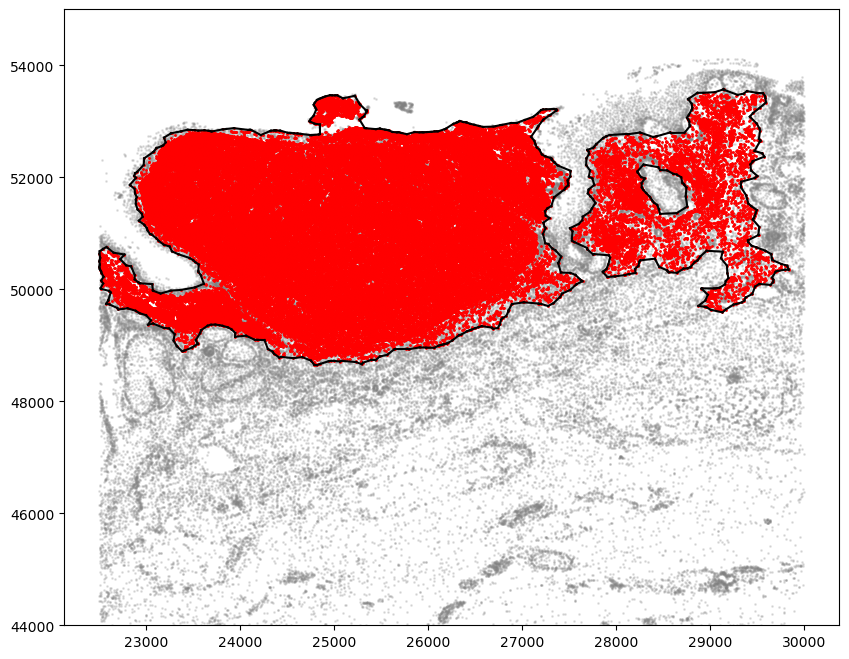

In [13]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for edge in boundaries:
    ax.plot(edge[:, 0], edge[:, 1], color="k")
plt.ylim(44000, 55000)    
plt.show()

# getExtendedBoundary & getShrunkenBoundary

`getExtendedBoundary` and `getShrunkenBoundary` can be used to expand or shrink the current boundary, which is useful to generate regions of interest

In [14]:
# Remove background. Anything beyond this will not be considered
ROI_boundaries, ROI_boundary_components = spc.spatial.getExtendedBoundary(
    boundaries_components, offset=800, minsize=20
)

shrunken_boundaries, shrunken_boundary_components = spc.spatial.getShrunkenBoundary(
    boundaries_components, offset=100, minsize=20
)

extended_boundaries, extended_boundary_components = spc.spatial.getExtendedBoundary(
    boundaries_components, offset=200, minsize=20
)
print(len(ROI_boundary_components[0]))
print(len(shrunken_boundary_components[0]))
print(len(extended_boundary_components[0]))

1
3
1


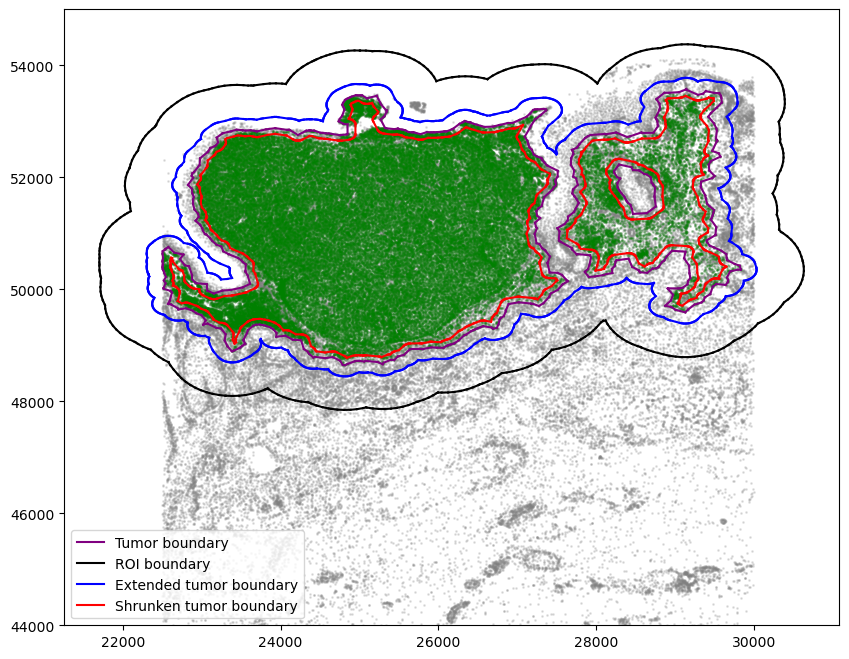

In [15]:
pointsize = 1
fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="green", alpha=0.2)

# Bounds of points in selected commnities
for i, ed in enumerate(boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="purple", label="Tumor boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="purple")


for i, ed in enumerate(ROI_boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="k", label="ROI boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="k")

for i, ed in enumerate(extended_boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="blue", label="Extended tumor boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="blue")

for i, ed in enumerate(shrunken_boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="red", label="Shrunken tumor boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="red")

plt.legend(loc="lower left")
plt.ylim(44000, 55000)
plt.show()


# assignPointsToRegion

Using 1 or more generated boundaries, cells can be assigned to different regions for downstream analysis

In [16]:
help(spc.spatial.assignPointsToRegions)

Help on function assignPointsToRegions in module spatialcells.spatial._assignPointsToRegions:

assignPointsToRegions(anndata, boundaries_list, region_names, assigncolumn='region', default='BG')
    Assign points to regions based on the boundaries. The region assignment is
    based on the order of the boundaries, so the innermost region should be the
    first element of boundaries_list.
    :param anndata: Anndata object
    :param boundaries_list: List of boundaries
    :param region_names: List of region names. The order and length should match boundaries_list
    :param assigncolumn: Column name for the region assignment
    :param default: Default region name for points that are not assigned to any region



In [17]:
regions = ["0In", "1Bi", "2Bo", "3Out"]
boundaries_list = [
    shrunken_boundary_components, 
    boundaries_components, 
    extended_boundary_components,
    ROI_boundary_components]
spc.spatial.assignPointsToRegions(adata, boundaries_list, regions, assigncolumn="region", default="BG")

Assigned points to region: 0In
Assigned points to region: 1Bi
Assigned points to region: 2Bo
Assigned points to region: 3Out


In [18]:
print("Regions:")
print(set(adata.obs['region']))
print("\nNumber of points in each region:")
print(adata.obs['region'].value_counts())

Regions:
{'3Out', '1Bi', 'BG', '2Bo', '0In'}

Number of points in each region:
0In     79444
BG      23673
1Bi     13059
3Out    10893
2Bo     10747
Name: region, dtype: int64


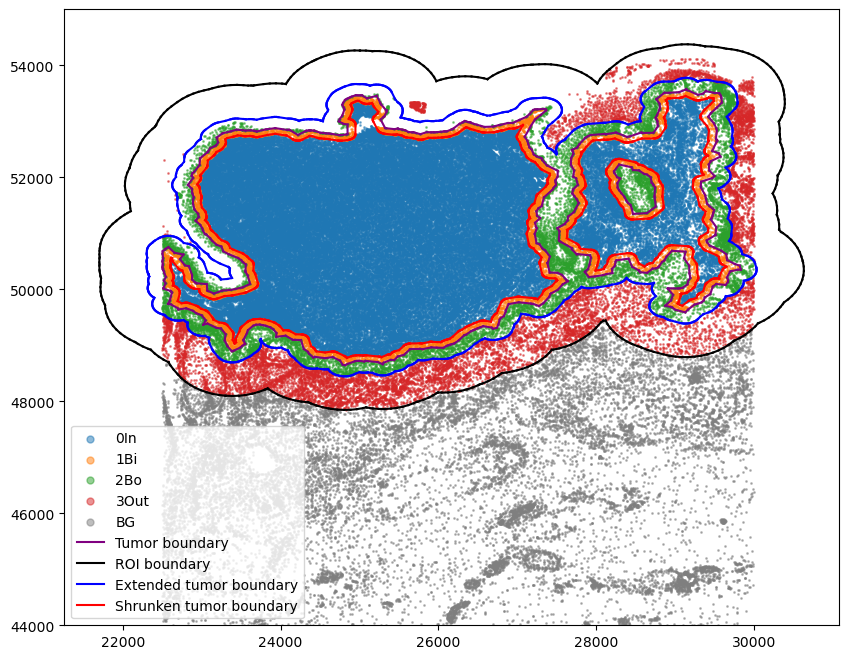

In [19]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:gray'
]

point_size = 1
fig, ax = plt.subplots(figsize=(10, 8))

for i, region in enumerate(sorted(set(adata.obs['region']))):
    tmp = adata[adata.obs.region==region]
    ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.5, label = region, color=colors[i])

# Bounds of points in selected commnities
for i, ed in enumerate(boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="purple", label="Tumor boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="purple")

for i, ed in enumerate(ROI_boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="k", label="ROI boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="k")

for i, ed in enumerate(extended_boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="blue", label="Extended tumor boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="blue")

for i, ed in enumerate(shrunken_boundaries):
    if i == 0:
        ax.plot(ed[:, 0], ed[:, 1], color="red", label="Shrunken tumor boundary")
    else:
        ax.plot(ed[:, 0], ed[:, 1], color="red")
plt.legend(loc="lower left", markerscale=5)
plt.ylim(44000, 55000)
plt.show()

Save adata object with cells assigned to each region for downstream analysis:

In [20]:
# adata.save("../data/example_adata_regions.h5ad")